# Importing libraries

In [1]:
import pandas as pd
#pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 10)
#pd.set_option('max_colwidth', None)

from platform import python_version

import warnings
warnings.filterwarnings("ignore")

import numpy as np

from unidecode import unidecode
import matplotlib.pyplot as plt
import matplotlib

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, wordpunct_tokenize

import sklearn

from sklearn.model_selection import train_test_split, StratifiedKFold


from sklearn.model_selection import cross_validate, cross_val_predict

#Linear models
from sklearn.linear_model import LogisticRegression

#SVM
from sklearn.svm import SVC

#Naive Bayes
from sklearn.naive_bayes import MultinomialNB, GaussianNB

#metrics
from sklearn.metrics import confusion_matrix, recall_score, f1_score, precision_score
from sklearn import metrics

#Text do vector
from sklearn.feature_extraction.text import TfidfVectorizer

#encoder
from sklearn.preprocessing import LabelEncoder

import datetime

from collections import Counter

seed = np.random.seed(5)

In [2]:
print('python',python_version())
print('pandas',pd.__version__)
print('numpy',np.__version__)
print('matplotlib', matplotlib.__version__)
print('sklearn', sklearn.__version__)


python 3.8.8
pandas 2.0.1
numpy 1.23.5
matplotlib 3.3.4
sklearn 1.3.0


In [3]:
lbl_multiclass = LabelEncoder()
lbl_binary = LabelEncoder()

# Defining functions

In [16]:
def load_data(arquivo, print_head=False):
    
    #Read the XLSX file
    df = pd.read_excel(arquivo)

    # Add the new column 'description' with the same content of 'expense_descriprion'
    # to preserve original data
    df['description'] = df.expense_description.apply(str)

    #Remove special characteres
    df['description'] = df.description.apply(unidecode)
    
    # Add a new column with expense_class_by_expert content
    df['class'] = df['expense_class_by_expert']

    df['y_class'] = lbl_multiclass.fit_transform(df['expense_class_by_expert'])
 
    df['binary_class'] = df.expense_class_by_expert.map({'CRED':'N', 'N':'N', 'PA_PIP':'Y', 'AJ':'Y', 'AC':'Y'})
    df['y_binary_class'] = lbl_binary.fit_transform(df['binary_class'])
    
    if(print_head):
        print(df.head(3))
    return df

def words_frequency(df, attribute, showSummary=False):
    words_by_line = df[attribute].apply(lambda x: ' '.join(wordpunct_tokenize(x)))

    text = " ".join(words_by_line.tolist())
    text_split = text.split()

    words_amount = Counter(text_split)
    words_frequency = list(words_amount.items())

    df_words_frequency = pd.DataFrame(words_frequency, columns=['Word', 'Frequency'])
    df_words_frequency['Length'] = df_words_frequency.Word.str.len()
    
    if showSummary:
        print(df_words_frequency.describe())
    
    return df_words_frequency

def words_distribution(df, attribute):
    all_words = [word for tokens in df[attribute].str.split() for word in tokens]
    sentence_lengths = [len(tokens) for tokens in df[attribute].str.strip()]
    VOCAB = sorted(list(set(all_words)))

    print("Total words: %s" % (len(all_words)))
    print("Single words: %s" % (len(VOCAB)))
    print("Short Description: %s" % min(sentence_lengths))
    print("Large Description: %s" % max(sentence_lengths))
    print("Mean Description: %s" % np.mean(sentence_lengths))
    print("Standard Deviation: %s" % np.std(sentence_lengths))
    
def words_scatter(df):
    f = plt.figure(figsize=(20, 7)) 
    plt.xlabel('Sequence')
    plt.ylabel('Amount')
    plt.scatter(df.index, df.Frequency, marker=".",c='green')
    plt.show()

def remove_no_letters(df, attribute):
    df[attribute] = df[attribute].str.lower()
    df[attribute] = df[attribute].str.replace(r"[0-9]", " ")
    df[attribute] = df[attribute].str.replace(r"[^A-Za-z]", " ")
    return df

def load_stopwords():
    
    #stopwords from nltk
    stop_words = list(map(unidecode, stopwords.words("portuguese")))
    
    #municipalities names 
    municipios = pd.read_csv("municipios.csv", sep="|").municipio.tolist()
    nomes = ' '.join([i for i in municipios])
    stop_words.extend(set(nomes.split()))
    
    # there is a city called 'professor'
    # So, the word professor was removed from stop word because means teacher in portuguese
    stop_words.remove("professor")
    
    #manually inserted words
    stop_words.extend(['secretaria', 'municipio', 'municipal', 'goias', 'departamento', 'prefeitura', 'empenho'])
    stop_words.extend(['empenha', 'valor', 'referente', 'ref', 'janeiro', 'mes', 'atender', 'despesa', 'ocorrer'])
    stop_words.extend(['conforme', 'anexo', 'emitido', 'nan','primeiro', 'segundo', 'terceiro', 'termo'])
    stop_words.extend(['aditivo','deste', 'desta'])
    
    return list(set(stop_words))

def load_less_frequent_words(df, min_ocorrencies = 10):
    text = " ".join(df.tolist())
    words_amount = Counter(text.split())
    words_frequency = list(words_amount.items())
    df_words = pd.DataFrame(words_frequency, columns=['Word', 'Length'])
    
    return list(df_words[df_words.Length <=min_ocorrencies].Word)

#Cleaning the data
def data_cleaning(df, attribute, remove_stop_words=True, minimal_occurrence=None, 
            minimal_characters=None, to_stemmer = None):
    
    #Remove all no letters from data text attribute
    df = remove_no_letters(df, attribute)

    #Remove stopwords
    stop_words = load_stopwords()
    df[attribute] = df[attribute].apply(lambda x: ' '.join([word.strip() for word in x.split() 
                                                                              if word not in (stop_words)]))

    #Stemmer
    if(to_stemmer != None):
        print('Stemmer')
        stemmer = SnowballStemmer("portuguese")
        df[attribute] = df[attribute].apply(lambda x: ' '.join([stemmer.stem(word) for word in x.split(" ")]))
    
    
    #Remove low frequency word
    if(minimal_occurrence != None):
        print('Minimal occurrence: ', minimal_occurrence)
        low_frequency_words = load_less_frequent_words(df[attribute], min_ocorrencies=minimal_occurrence)
        print(len(low_frequency_words))
        
        df[attribute] = df[attribute].apply(lambda x: ' '.join([word.strip() for word in x.split() 
                                                                              if word not in (low_frequency_words)]))
 
    #Remove words with less than minimum characters
    if(minimal_characters):
        print('Minimal characters', minimal_characters)
        df[attribute] = df[attribute].apply(lambda x: ' '.join([word.strip() for word in x.split() 
                                                                if len(word.strip()) >= minimal_characters]))

    #Remove null and duplicates rows
    print('All dataset: ', df.shape)
    df[attribute] = df[attribute].str.strip()
    df.drop_duplicates(inplace=True, subset=attribute, keep='first')
    print('After removing duplicates: ', df.shape)
    df.drop(labels=(df.loc[df[attribute] ==''].index), inplace=True)
    print('After discarding no letters rows', df.shape)
    
    return df

def split_data(df, label, k=10, seed=0):
    print('Splitint the dataset into k =', k)
    #df = df.sample(frac=1, random_state=seed).reset_index(drop=True)
    #return np.array_split(df, k)

    response = list()
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=seed)
    
    for __, test_index in skf.split(df, df[label]):
        response.append(df.loc[test_index])
    
    return response

def print_amount_by_fold(groups):
    print('\nSamples by Fold\n')
    
    counter = 1
    for i in groups:
        print('Fold:', counter,'-', len(i))
        counter = counter + 1
    print('\n\n')

def print_sample_distribution(groups, attribute):
    print('\nDistribution by Fold\n')
    
    counter = 1
    for i in groups:
        print('Fold:', counter)
        df = pd.DataFrame(i)
        print(round(df[attribute].value_counts()), '\n')
        counter = counter + 1
    print('\n\n')
    
def prediction(model, folds, class_attribute, sparse_matrix=True, lbl_encoder=None, verbose=False):
    
    if((verbose) & (lbl_encoder==None)):
        print('Verbose mode demands a label encoder')
        return 
    
    folds_return = list()
    
    k = len(folds)
    
    if (verbose):
        print('Model:', model, 'Class attribute:', class_attribute)

    for k_i in range(0, k):
        if (verbose):
            print('Iteration #:',k_i+1,'\n\n') 
        
        folds_copy = folds.copy()
        
        # k_i index is test set
        f_test = folds_copy.pop(k_i)

        #other slices are train set
        f_train = pd.concat(folds_copy)
            
        #TFIDF Vectorizer instance
        vectorizer = TfidfVectorizer()

        # Use the train set to traning the tfidf vectorizer
        f_train_vet = vectorizer.fit_transform(f_train.description)
        f_test_vet = vectorizer.transform(f_test.description)
        
        if(not(sparse_matrix) or (str(model).startswith('GaussianNB')) ):
            f_train_vet = f_train_vet.toarray()
            f_test_vet = f_test_vet.toarray()
        
           
        try:
            #Train the model
            model.fit(f_train_vet, f_train[class_attribute], )
            
            #Predictions
            predicted_classes =  model.predict(f_test_vet);

            #Assign fold and predicted class to dataset to return
            f_test['y_predicted'] = np.array(predicted_classes).transpose()
            f_test['fold'] = k_i+1

            #Store the class results to return
            folds_return.append(f_test)
            
            if(verbose):
                get_metrics(f_test, class_attribute, lbl_encoder, True)
        except Exception as ex:
            print('Except: ', ex)
            break
    
    return folds_return

# Show metrics
def get_metrics(df, class_attribute, lbl_encoder, show=False):
    
    real = df[class_attribute]
    predicted = df['y_predicted']
    
    f1 = metrics.f1_score(y_true = real, y_pred = predicted, average='macro').round(4)
    accuracy = metrics.accuracy_score(y_true = real, y_pred = predicted ).round(4) 
    precision = metrics.precision_score(y_true = real, y_pred = predicted , average='macro').round(4)
    recall = metrics.recall_score(y_true = real, y_pred = predicted , average='macro').round(4)
    
    if(show):
        print('\n','-'*20,'CONFUSION MATRIX','-'*20, '\n')
        matrix = confusion_matrix(y_true = real, y_pred = predicted )
        cm = pd.DataFrame(matrix.T, columns=lbl_encoder.classes_, index = lbl_encoder.classes_)
        print(cm) 
        #print(matriz.T)
        print('\n\n')


        print('-'*18,'CLASSIFICATION REPORT','-'*18)
        print('\n',metrics.classification_report(y_true = real, y_pred = predicted, 
                                            digits=2, target_names=lbl_encoder.classes_))

        
        print('-'*20,'GENERAL METRICS','-'*20)
        print('\nAccuracy', accuracy, '; Precision', precision, '; Recall', recall, '; F-Score', f1)
        print('\n')
    
    all_metrics = metrics.classification_report(y_true = real, y_pred = predicted , digits=4, 
                                         output_dict=True, target_names=lbl_encoder.classes_)
    
    return [accuracy, precision, recall, f1, all_metrics, matrix.ravel()]   

def normalizeRows(M):
    sums = M.sum()
    return M / sums

def normalized_cm(df):
    cm_df = df['Confusion_matrix'].sum()
    cm_df = cm_df.reshape([5,5])
    cm = pd.DataFrame(normalizeRows(cm_df), columns=lbl_multiclass.classes_, index = lbl_multiclass.classes_)
    return cm.transpose()

def mean_cm(df):
    cm_df = df['Confusion_matrix'].sum()
    cm_df = cm_df.reshape([5,5]) / 10
    cm = pd.DataFrame(cm_df, columns=lbl_multiclass.classes_, index = lbl_multiclass.classes_)
    return cm.transpose()

def binary_normalized_cm(df):
    cm_df = df['PositiveAndNegativeMetrics'].sum()
    cm_df = cm_df.reshape([2,2])
    cm = pd.DataFrame(normalizeRows(cm_df), columns=lbl_binary.classes_, index = lbl_binary.classes_)
    return cm

## Call load_data function

Total words: 444546
Single words: 27062
Short Description: 6
Large Description: 261
Mean Description: 170.9567655994391
Standard Deviation: 44.68935911224313


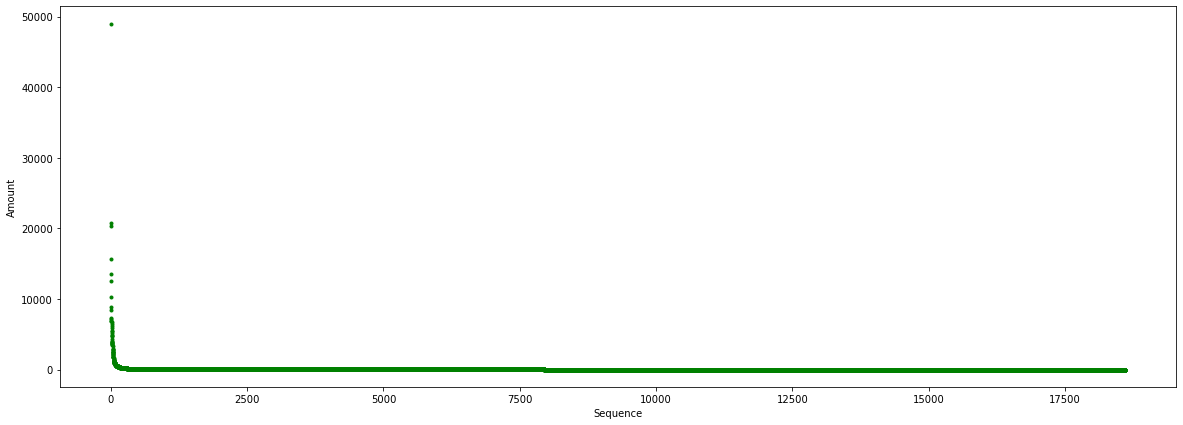

In [17]:
pd.set_option('display.max_rows', 10)
loaded_data = load_data("tcm_expenses.xlsx")
freq = words_frequency(loaded_data, 'description').sort_values(by=['Frequency'], ascending=False, ignore_index=True)
words_distribution(loaded_data, 'description')
words_scatter(freq)

In [18]:
total_divergent = len(loaded_data[loaded_data['class'] != loaded_data['expense_class_by_code']])
print('Total divergent instances =', total_divergent)
print('Percent ', (total_divergent / len(loaded_data)*100))

Total divergent instances = 3027
Percent  17.685206824024306


In [19]:
manual_label, code_label = loaded_data['class'] , loaded_data['expense_class_by_code']

In [20]:
matrix = metrics.confusion_matrix(y_true = manual_label, y_pred=code_label, labels=lbl_multiclass.classes_ )
cm = pd.DataFrame(matrix.T, columns=lbl_multiclass.classes_, index = lbl_multiclass.classes_)
cm

,AC,AJ,CRED,N,PA_PIP
AC,75,0,1,0,0
AJ,1,50,0,0,0
CRED,0,0,396,0,0
N,46,44,276,13568,105
PA_PIP,0,0,0,0,0


In [21]:
#'true', 'pred', 'all'
matrix_normalized = metrics.confusion_matrix(y_true = manual_label, y_pred=code_label, 
                                             labels=lbl_multiclass.classes_ , normalize='all')
cm_normalized = pd.DataFrame(matrix_normalized.T, columns=lbl_multiclass.classes_, index = lbl_multiclass.classes_)
cm_normalized

,AC,AJ,CRED,N,PA_PIP
AC,0.005150,0.000000,0.000069,0.00000,0.000000
AJ,0.000069,0.003434,0.000000,0.00000,0.000000
CRED,0.000000,0.000000,0.027194,0.00000,0.000000
N,0.003159,0.003022,0.018953,0.93174,0.007211
PA_PIP,0.000000,0.000000,0.000000,0.00000,0.000000


# Preprocessing

Minimal occurrence:  4
8
Minimal characters 4
All dataset:  (16868, 11)
After removing duplicates:  (16865, 11)
After discarding no letters rows (16865, 11)


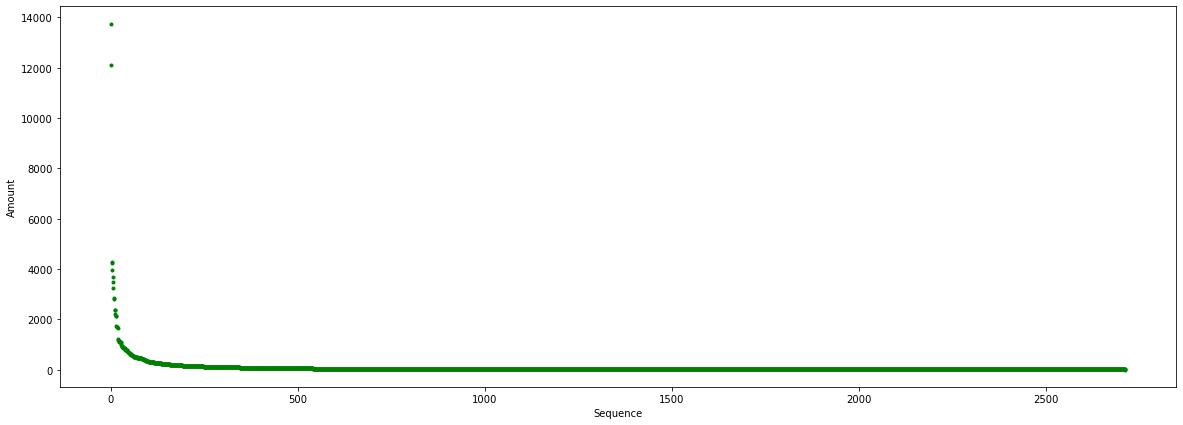

In [30]:
dataset = data_cleaning(loaded_data, 'description', remove_stop_words=True, 
                        minimal_occurrence=4,
                        minimal_characters=4).reset_index()
frequency_after_data_cleaning = words_frequency(dataset, 'description').sort_values(by=['Frequency'], 
                                                                                    ascending=False, ignore_index=True)
words_scatter(frequency_after_data_cleaning)

In [28]:
all_words = [word for tokens in dataset['description'].str.split() for word in tokens]
dataset['sentence_lengths'] = [len(tokens) for tokens in dataset['description'].str.strip()]
dataset['tokens'] = [tokens for tokens in dataset['description'].str.strip()]
VOCAB = sorted(list(set(all_words)))

print("Total words: %s" % (len(all_words)))
print("Single words: %s" % (len(VOCAB)))
print("Short Description: %s" % min(dataset['sentence_lengths']))
print("Large Description: %s" % max(dataset['sentence_lengths']))
print("Mean Description: %s" % np.mean(dataset['sentence_lengths']))
print("Standard Deviation: %s" % np.std(dataset['sentence_lengths']))

Total words: 167829
Single words: 3417
Short Description: 5
Large Description: 194
Mean Description: 88.61109793692198
Standard Deviation: 29.27217546156147


In [29]:
dataset[dataset.sentence_lengths <=15]

,index,id,expense_description,amount,expense_code,expense_class_by_code,expense_class_by_expert,description,class,y_class,binary_class,y_binary_class,sentence_lengths,tokens
998,1011,67853303,valor que se empenha para ocorrer a despesa co...,3333.25,31900400,PA,PA_PIP,ferias pagas,PA_PIP,4,Y,1,12,ferias pagas
1012,1026,67884699,empenho da folha de pagamento de 13 salario19 ...,560.33,31900900,PA,PA_PIP,folha pagamento,PA_PIP,4,Y,1,15,folha pagamento
1042,1056,67804521,abono permanencia,0.00,31901199,PA,PA_PIP,abono,PA_PIP,4,Y,1,5,abono
1578,1608,68175026,empenho da folha saae 012020comissao 1673,2426.60,31901105,PA,PA_PIP,folha saae,PA_PIP,4,Y,1,10,folha saae
1620,1650,67784284,valor que se empenha para atender despesa com ...,3254.03,31901103,PA,PA_PIP,horas 2020.,PA_PIP,4,Y,1,11,horas 2020.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13754,13945,68103699,aquisição de uma chave contador,725.41,33903026,N,N,aquisicao,N,3,N,0,9,aquisicao
13960,14160,68103641,despesa com atualização e cancelamento nirf.,680.00,33903999,N,N,atualizacao,N,3,N,0,11,atualizacao
14574,14784,67804850,serviço medicos,52082.71,33903630,N,N,servico medicos,N,3,N,0,15,servico medicos
14872,15089,67804709,residentes precepores dezembro 2019,4774.29,31903499,OUTROS,N,dezembro 2019,N,3,N,0,13,dezembro 2019


In [31]:
words_distribution(dataset, 'description')

Total words: 167778
Single words: 3409
Short Description: 5
Large Description: 194
Mean Description: 88.60017788319004
Standard Deviation: 29.268564340452734


In [12]:
frequency_after_data_cleaning.sort_values(by=['Frequency'] )

,Word,Frequency,Length
2604,intervencao,4,11
2599,tarjeta,4,7
2600,semusa,4,6
2603,anulacao,4,8
2602,cred,4,4
...,...,...,...
4,prestacao,3263,9
3,despesas,3493,8
2,manutencao,3709,10
1,servicos,3975,8


In [13]:
for cls in lbl_multiclass.classes_:
    print('Classe:',cls,'\n')
    words_distribution(dataset[dataset['class'] == cls], 'description')
    print('\n\n')

Classe: AC 

Total words: 1478
Single words: 210
Short Description: 43
Large Description: 183
Mean Description: 115.27642276422765
Standard Deviation: 33.699364499812



Classe: AJ 

Total words: 1028
Single words: 203
Short Description: 43
Large Description: 179
Mean Description: 107.7127659574468
Standard Deviation: 31.699259116258414



Classe: CRED 

Total words: 7811
Single words: 587
Short Description: 16
Large Description: 187
Mean Description: 105.99269005847954
Standard Deviation: 26.381284441569125



Classe: N 

Total words: 128296
Single words: 2585
Short Description: 4
Large Description: 216
Mean Description: 83.34598197934217
Standard Deviation: 28.107051923317297



Classe: PA_PIP 

Total words: 17832
Single words: 988
Short Description: 5
Large Description: 180
Mean Description: 66.95256087321579
Standard Deviation: 22.69518048404712





# Experiments

In [14]:
#Definitions
models = [LogisticRegression(), SVC(), MultinomialNB()]
#models = [SVC()]
classes = {'multiclass': ['y_class', lbl_multiclass], 'binary': ['y_binary_class', lbl_binary]}

metrics_all_models = list()

seeds = range(0,10)

for seed in seeds:
    
    for approach, lbl_config in classes.items():
        
        class_attribute = lbl_config[0]
        encoder = lbl_config[1]
        
        #split the data
        folds = split_data(dataset, label=class_attribute, seed=seed)

        for model in models:
            print('#'*70)
            print('EXPERIMENT -> Seed ', seed, ' Approach: ', approach, ' Model: ', model)
            print('#'*70)
            folds_return = prediction(model, folds, class_attribute, lbl_encoder=encoder)
            metrics_model = [str(seed), str(model), approach]
            metrics_model.extend(get_metrics(pd.concat(folds_return), class_attribute, encoder, show=True))
            metrics_all_models.append(metrics_model)

Splitint the dataset into k = 10
######################################################################
EXPERIMENT -> Seed  0  Approach:  multiclass  Model:  LogisticRegression()
######################################################################

 -------------------- CONFUSION MATRIX -------------------- 

        AC  AJ  CRED      N  PA_PIP
AC      99   1     0      1       0
AJ       0  65     0      4       0
CRED     0   0   554     32       3
N       24  28   129  13509     208
PA_PIP   0   0     1    105    2171



------------------ CLASSIFICATION REPORT ------------------

               precision    recall  f1-score   support

          AC       0.98      0.80      0.88       123
          AJ       0.94      0.69      0.80        94
        CRED       0.94      0.81      0.87       684
           N       0.97      0.99      0.98     13651
      PA_PIP       0.95      0.91      0.93      2382

    accuracy                           0.97     16934
   macro avg       0.96   


 -------------------- CONFUSION MATRIX -------------------- 

        AC  AJ  CRED      N  PA_PIP
AC      34   0     0      0       0
AJ       0   3     0      0       0
CRED     0   1   519    110       1
N       89  90   163  13196     154
PA_PIP   0   0     2    345    2227



------------------ CLASSIFICATION REPORT ------------------

               precision    recall  f1-score   support

          AC       1.00      0.28      0.43       123
          AJ       1.00      0.03      0.06        94
        CRED       0.82      0.76      0.79       684
           N       0.96      0.97      0.97     13651
      PA_PIP       0.87      0.93      0.90      2382

    accuracy                           0.94     16934
   macro avg       0.93      0.59      0.63     16934
weighted avg       0.94      0.94      0.94     16934

-------------------- GENERAL METRICS --------------------

Accuracy 0.9436 ; Precision 0.9303 ; Recall 0.5937 ; F-Score 0.6297


Splitint the dataset into k = 10
#####


 -------------------- CONFUSION MATRIX -------------------- 

       N     Y
N  13973   241
Y    362  2358



------------------ CLASSIFICATION REPORT ------------------

               precision    recall  f1-score   support

           N       0.98      0.97      0.98     14335
           Y       0.87      0.91      0.89      2599

    accuracy                           0.96     16934
   macro avg       0.92      0.94      0.93     16934
weighted avg       0.97      0.96      0.96     16934

-------------------- GENERAL METRICS --------------------

Accuracy 0.9644 ; Precision 0.925 ; Recall 0.941 ; F-Score 0.9328


Splitint the dataset into k = 10
######################################################################
EXPERIMENT -> Seed  3  Approach:  multiclass  Model:  LogisticRegression()
######################################################################

 -------------------- CONFUSION MATRIX -------------------- 

        AC  AJ  CRED      N  PA_PIP
AC      99   1     0    


 -------------------- CONFUSION MATRIX -------------------- 

        AC  AJ  CRED      N  PA_PIP
AC      34   0     0      0       0
AJ       0   2     0      0       0
CRED     0   1   525    113       1
N       89  91   157  13194     147
PA_PIP   0   0     2    344    2234



------------------ CLASSIFICATION REPORT ------------------

               precision    recall  f1-score   support

          AC       1.00      0.28      0.43       123
          AJ       1.00      0.02      0.04        94
        CRED       0.82      0.77      0.79       684
           N       0.96      0.97      0.97     13651
      PA_PIP       0.87      0.94      0.90      2382

    accuracy                           0.94     16934
   macro avg       0.93      0.59      0.63     16934
weighted avg       0.95      0.94      0.94     16934

-------------------- GENERAL METRICS --------------------

Accuracy 0.9442 ; Precision 0.9302 ; Recall 0.5939 ; F-Score 0.6268


Splitint the dataset into k = 10
#####


 -------------------- CONFUSION MATRIX -------------------- 

       N     Y
N  13981   236
Y    354  2363



------------------ CLASSIFICATION REPORT ------------------

               precision    recall  f1-score   support

           N       0.98      0.98      0.98     14335
           Y       0.87      0.91      0.89      2599

    accuracy                           0.97     16934
   macro avg       0.93      0.94      0.93     16934
weighted avg       0.97      0.97      0.97     16934

-------------------- GENERAL METRICS --------------------

Accuracy 0.9652 ; Precision 0.9266 ; Recall 0.9423 ; F-Score 0.9342


Splitint the dataset into k = 10
######################################################################
EXPERIMENT -> Seed  6  Approach:  multiclass  Model:  LogisticRegression()
######################################################################

 -------------------- CONFUSION MATRIX -------------------- 

         AC  AJ  CRED      N  PA_PIP
AC      100   1     0


 -------------------- CONFUSION MATRIX -------------------- 

        AC  AJ  CRED      N  PA_PIP
AC      35   0     0      0       0
AJ       0   3     0      0       0
CRED     0   1   524    112       1
N       88  90   159  13198     150
PA_PIP   0   0     1    341    2231



------------------ CLASSIFICATION REPORT ------------------

               precision    recall  f1-score   support

          AC       1.00      0.28      0.44       123
          AJ       1.00      0.03      0.06        94
        CRED       0.82      0.77      0.79       684
           N       0.96      0.97      0.97     13651
      PA_PIP       0.87      0.94      0.90      2382

    accuracy                           0.94     16934
   macro avg       0.93      0.60      0.63     16934
weighted avg       0.95      0.94      0.94     16934

-------------------- GENERAL METRICS --------------------

Accuracy 0.9443 ; Precision 0.9306 ; Recall 0.5972 ; F-Score 0.6327


Splitint the dataset into k = 10
#####


 -------------------- CONFUSION MATRIX -------------------- 

       N     Y
N  13963   236
Y    372  2363



------------------ CLASSIFICATION REPORT ------------------

               precision    recall  f1-score   support

           N       0.98      0.97      0.98     14335
           Y       0.86      0.91      0.89      2599

    accuracy                           0.96     16934
   macro avg       0.92      0.94      0.93     16934
weighted avg       0.97      0.96      0.96     16934

-------------------- GENERAL METRICS --------------------

Accuracy 0.9641 ; Precision 0.9237 ; Recall 0.9416 ; F-Score 0.9324


Splitint the dataset into k = 10
######################################################################
EXPERIMENT -> Seed  9  Approach:  multiclass  Model:  LogisticRegression()
######################################################################

 -------------------- CONFUSION MATRIX -------------------- 

        AC  AJ  CRED      N  PA_PIP
AC      99   1     0  

In [15]:
pd.set_option('display.max_rows', None)
df_results = pd.DataFrame(metrics_all_models, columns=['Seed', 'Model', 'Approach', 'Accuracy', 'Precision', 'Recall', 'F1', 'All Metrics', 'PositiveAndNegativeMetrics'])
df_results

,Seed,Model,Approach,Accuracy,Precision,Recall,F1,All Metrics,PositiveAndNegativeMetrics
0,0,LogisticRegression(),multiclass,0.9683,0.9577,0.8415,0.8929,"{'AC': {'precision': 0.9801980198019802, 'reca...","[99, 0, 0, 24, 0, 1, 65, 0, 28, 0, 0, 0, 554, ..."
1,0,SVC(),multiclass,0.9754,0.9673,0.8738,0.9162,"{'AC': {'precision': 0.9819819819819819, 'reca...","[109, 0, 0, 14, 0, 1, 69, 0, 24, 0, 0, 0, 563,..."
2,0,MultinomialNB(),multiclass,0.9443,0.9305,0.5926,0.6269,"{'AC': {'precision': 1.0, 'recall': 0.26016260...","[32, 0, 0, 91, 0, 0, 3, 1, 90, 0, 0, 0, 525, 1..."
3,0,LogisticRegression(),binary,0.9743,0.9622,0.9371,0.9491,"{'N': {'precision': 0.979110651499483, 'recall...","[14202, 133, 303, 2296]"
4,0,SVC(),binary,0.9832,0.9761,0.9584,0.9670,"{'N': {'precision': 0.9860918903957929, 'recal...","[14251, 84, 201, 2398]"
5,0,MultinomialNB(),binary,0.9646,0.9252,0.9418,0.9332,"{'N': {'precision': 0.9833216045038705, 'recal...","[13973, 362, 237, 2362]"
6,1,LogisticRegression(),multiclass,0.9681,0.9614,0.8392,0.8929,"{'AC': {'precision': 0.98, 'recall': 0.7967479...","[98, 0, 0, 25, 0, 1, 65, 0, 28, 0, 0, 0, 553, ..."
7,1,SVC(),multiclass,0.9751,0.9693,0.8727,0.9165,"{'AC': {'precision': 0.9818181818181818, 'reca...","[108, 0, 0, 15, 0, 1, 70, 0, 23, 0, 0, 0, 558,..."
8,1,MultinomialNB(),multiclass,0.9436,0.9303,0.5937,0.6297,"{'AC': {'precision': 1.0, 'recall': 0.27642276...","[34, 0, 0, 89, 0, 0, 3, 1, 90, 0, 0, 0, 519, 1..."
9,1,LogisticRegression(),binary,0.9741,0.9625,0.9360,0.9487,"{'N': {'precision': 0.9787102108309219, 'recal...","[14205, 130, 309, 2290]"


In [39]:
df_results_binary = df_results[df_results.Approach == 'binary'].set_index('Seed')

for lbl in lbl_binary.classes_:
    #df_results_binary[lbl+'_P'] = df_results_binary['All Metrics'].apply(lambda x:x[lbl]['precision'])
    #df_results_binary[lbl+'_R'] = df_results_binary['All Metrics'].apply(lambda x:x[lbl]['recall'])
    df_results_binary[lbl+'_F1'] = df_results_binary['All Metrics'].apply(lambda x:x[lbl]['f1-score'])

df_results_binary.drop(columns=['All Metrics'], inplace=True)
df_results_binary

,Model,Approach,Accuracy,Precision,Recall,F1,PositiveAndNegativeMetrics,N_F1,Y_F1
Seed,,,,,,,,,
0,LogisticRegression(),binary,0.9743,0.9622,0.9371,0.9491,"[14202, 133, 303, 2296]",0.984882,0.913286
0,SVC(),binary,0.9832,0.9761,0.9584,0.9670,"[14251, 84, 201, 2398]",0.990100,0.943909
0,MultinomialNB(),binary,0.9646,0.9252,0.9418,0.9332,"[13973, 362, 237, 2362]",0.979016,0.887469
1,LogisticRegression(),binary,0.9741,0.9625,0.9360,0.9487,"[14205, 130, 309, 2290]",0.984783,0.912532
1,SVC(),binary,0.9837,0.9774,0.9592,0.9680,"[14257, 78, 198, 2401]",0.990413,0.945648
1,MultinomialNB(),binary,0.9646,0.9250,0.9421,0.9333,"[13971, 364, 235, 2364]",0.979013,0.887554
2,LogisticRegression(),binary,0.9743,0.9627,0.9368,0.9492,"[14205, 130, 305, 2294]",0.984919,0.913398
2,SVC(),binary,0.9833,0.9761,0.9589,0.9673,"[14250, 85, 198, 2401]",0.990168,0.944346
2,MultinomialNB(),binary,0.9644,0.9250,0.9410,0.9328,"[13973, 362, 241, 2358]",0.978878,0.886633


In [40]:
df_results_binary

,Model,Approach,Accuracy,Precision,Recall,F1,PositiveAndNegativeMetrics,N_F1,Y_F1
Seed,,,,,,,,,
0,LogisticRegression(),binary,0.9743,0.9622,0.9371,0.9491,"[14202, 133, 303, 2296]",0.984882,0.913286
0,SVC(),binary,0.9832,0.9761,0.9584,0.9670,"[14251, 84, 201, 2398]",0.990100,0.943909
0,MultinomialNB(),binary,0.9646,0.9252,0.9418,0.9332,"[13973, 362, 237, 2362]",0.979016,0.887469
1,LogisticRegression(),binary,0.9741,0.9625,0.9360,0.9487,"[14205, 130, 309, 2290]",0.984783,0.912532
1,SVC(),binary,0.9837,0.9774,0.9592,0.9680,"[14257, 78, 198, 2401]",0.990413,0.945648
1,MultinomialNB(),binary,0.9646,0.9250,0.9421,0.9333,"[13971, 364, 235, 2364]",0.979013,0.887554
2,LogisticRegression(),binary,0.9743,0.9627,0.9368,0.9492,"[14205, 130, 305, 2294]",0.984919,0.913398
2,SVC(),binary,0.9833,0.9761,0.9589,0.9673,"[14250, 85, 198, 2401]",0.990168,0.944346
2,MultinomialNB(),binary,0.9644,0.9250,0.9410,0.9328,"[13973, 362, 241, 2358]",0.978878,0.886633


## Resultados do modelo SVM Binário

In [60]:
df_binary_svc = df_results_binary[df_results_binary.Model == 'SVC()']
df_binary_svc.describe()[1:3].round(2)

,Accuracy,Precision,Recall,F1,N_F1,Y_F1
mean,0.98,0.98,0.96,0.97,0.99,0.94
std,0.00,0.00,0.00,0.00,0.00,0.00


In [64]:
df_results_binary[df_results_binary.Model == 'LogisticRegression()'].describe()[1:3].round(4)

,Accuracy,Precision,Recall,F1,N_F1,Y_F1
mean,0.9743,0.9625,0.9370,0.9492,0.9849,0.9134
std,0.0001,0.0004,0.0005,0.0003,0.0001,0.0005


In [65]:
df_results_binary[df_results_binary.Model == 'MultinomialNB()'].describe()[1:3].round(4)

,Accuracy,Precision,Recall,F1,N_F1,Y_F1
mean,0.9646,0.9252,0.9417,0.9332,0.9790,0.8873
std,0.0003,0.0008,0.0005,0.0005,0.0002,0.0009


In [46]:
label_x = pd.DataFrame(range(0,10), columns=['X'])
label_x.X = label_x.X.apply(lambda x: ('Repetição ' + str(x+1)))
label_x

,X
0,Repetição 1
1,Repetição 2
2,Repetição 3
3,Repetição 4
4,Repetição 5
5,Repetição 6
6,Repetição 7
7,Repetição 8
8,Repetição 9
9,Repetição 10


f = plt.figure(figsize=(10, 7)) 
plt.title('Experimento Binário - E1')
plt.ylabel('F1')
plt.plot(label_x.X, df_results_binary[df_results_binary.Model == 'LogisticRegression()'].F1, marker=".",c='green', label='LogisticRegression')
plt.plot(label_x.X, df_results_binary[df_results_binary.Model == 'SVC()'].F1, marker=".",c='red', label='SVC')
plt.plot(label_x.X, df_results_binary[df_results_binary.Model == 'MultinomialNB()'].F1, marker=".",c='blue', label='MultinomialNB')
plt.grid(True)
plt.legend(bbox_to_anchor = (0.99,0.8))
f.autofmt_xdate()
#plt.show()

In [47]:
df_binary_svc.F1

Seed
0    0.9670
1    0.9680
2    0.9673
3    0.9660
4    0.9678
5    0.9678
6    0.9667
7    0.9681
8    0.9685
9    0.9671
Name: F1, dtype: float64

df_results_binary.groupby(['Model']).mean().round(3).sort_values(by=['F1'], ascending=False)

df_results_binary.sort_values(by=['F1'], ascending=False).groupby(['Model']).std().round(3)

In [48]:
df_results_multiclass = df_results[df_results.Approach == 'multiclass'].set_index('Seed')

for lbl in lbl_multiclass.classes_:
    #df_results_multiclass[lbl+'_P'] = df_results_multiclass['All Metrics'].apply(lambda x:x[lbl]['precision'])
    #df_results_multiclass[lbl+'_R'] = df_results_multiclass['All Metrics'].apply(lambda x:x[lbl]['recall'])
    df_results_multiclass[lbl+'_F1'] = df_results_multiclass['All Metrics'].apply(lambda x:x[lbl]['f1-score'])

df_results_multiclass.drop(columns=['All Metrics'], inplace=True)
df_results_multiclass.round(2)

,Model,Approach,Accuracy,Precision,Recall,F1,PositiveAndNegativeMetrics,AC_F1,AJ_F1,CRED_F1,N_F1,PA_PIP_F1
Seed,,,,,,,,,,,,
0,LogisticRegression(),multiclass,0.97,0.96,0.84,0.89,"[99, 0, 0, 24, 0, 1, 65, 0, 28, 0, 0, 0, 554, ...",0.88,0.80,0.87,0.98,0.93
0,SVC(),multiclass,0.98,0.97,0.87,0.92,"[109, 0, 0, 14, 0, 1, 69, 0, 24, 0, 0, 0, 563,...",0.93,0.83,0.89,0.99,0.95
0,MultinomialNB(),multiclass,0.94,0.93,0.59,0.63,"[32, 0, 0, 91, 0, 0, 3, 1, 90, 0, 0, 0, 525, 1...",0.41,0.06,0.79,0.97,0.90
1,LogisticRegression(),multiclass,0.97,0.96,0.84,0.89,"[98, 0, 0, 25, 0, 1, 65, 0, 28, 0, 0, 0, 553, ...",0.88,0.80,0.87,0.98,0.93
1,SVC(),multiclass,0.98,0.97,0.87,0.92,"[108, 0, 0, 15, 0, 1, 70, 0, 23, 0, 0, 0, 558,...",0.93,0.84,0.88,0.98,0.95
1,MultinomialNB(),multiclass,0.94,0.93,0.59,0.63,"[34, 0, 0, 89, 0, 0, 3, 1, 90, 0, 0, 0, 519, 1...",0.43,0.06,0.79,0.97,0.90
2,LogisticRegression(),multiclass,0.97,0.96,0.85,0.90,"[100, 0, 0, 23, 0, 1, 66, 0, 27, 0, 0, 0, 555,...",0.89,0.81,0.87,0.98,0.93
2,SVC(),multiclass,0.98,0.97,0.88,0.92,"[108, 0, 0, 15, 0, 1, 71, 0, 22, 0, 0, 0, 563,...",0.93,0.85,0.89,0.98,0.95
2,MultinomialNB(),multiclass,0.94,0.93,0.60,0.63,"[35, 0, 0, 88, 0, 0, 3, 1, 90, 0, 0, 0, 519, 1...",0.44,0.06,0.79,0.97,0.90


In [49]:
df_results_multiclass_svc = df_results_multiclass[df_results_multiclass.Model == 'SVC()']
df_results_multiclass_svc['Confusion_matrix'] = df_results_multiclass_svc.PositiveAndNegativeMetrics
df_results_multiclass_svc

,Model,Approach,Accuracy,Precision,Recall,F1,PositiveAndNegativeMetrics,AC_F1,AJ_F1,CRED_F1,N_F1,PA_PIP_F1,Confusion_matrix
Seed,,,,,,,,,,,,,
0,SVC(),multiclass,0.9754,0.9673,0.8738,0.9162,"[109, 0, 0, 14, 0, 1, 69, 0, 24, 0, 0, 0, 563,...",0.931624,0.826347,0.888013,0.985067,0.949957,"[109, 0, 0, 14, 0, 1, 69, 0, 24, 0, 0, 0, 563,..."
1,SVC(),multiclass,0.9751,0.9693,0.8727,0.9165,"[108, 0, 0, 15, 0, 1, 70, 0, 23, 0, 0, 0, 558,...",0.927039,0.838323,0.882213,0.984852,0.949936,"[108, 0, 0, 15, 0, 1, 70, 0, 23, 0, 0, 0, 558,..."
2,SVC(),multiclass,0.9753,0.9694,0.8763,0.9187,"[108, 0, 0, 15, 0, 1, 71, 0, 22, 0, 0, 0, 563,...",0.927039,0.845238,0.886614,0.984993,0.949530,"[108, 0, 0, 15, 0, 1, 71, 0, 22, 0, 0, 0, 563,..."
3,SVC(),multiclass,0.9751,0.9674,0.8681,0.9129,"[107, 0, 0, 16, 0, 1, 68, 0, 25, 0, 0, 0, 563,...",0.922414,0.819277,0.888713,0.984890,0.949261,"[107, 0, 0, 16, 0, 1, 68, 0, 25, 0, 0, 0, 563,..."
4,SVC(),multiclass,0.9756,0.9672,0.8748,0.9167,"[109, 0, 0, 14, 0, 1, 69, 0, 24, 0, 0, 0, 566,...",0.931624,0.826347,0.890637,0.985135,0.949797,"[109, 0, 0, 14, 0, 1, 69, 0, 24, 0, 0, 0, 566,..."
5,SVC(),multiclass,0.9749,0.9679,0.8738,0.9164,"[109, 0, 0, 14, 0, 1, 69, 0, 24, 0, 0, 0, 564,...",0.931624,0.831325,0.885400,0.984735,0.948718,"[109, 0, 0, 14, 0, 1, 69, 0, 24, 0, 0, 0, 564,..."
6,SVC(),multiclass,0.9756,0.9680,0.8777,0.9190,"[109, 0, 0, 14, 0, 1, 71, 0, 22, 0, 0, 0, 562,...",0.931624,0.840237,0.887836,0.985140,0.949957,"[109, 0, 0, 14, 0, 1, 71, 0, 22, 0, 0, 0, 562,..."
7,SVC(),multiclass,0.9752,0.9664,0.8722,0.9150,"[108, 0, 0, 15, 0, 1, 69, 0, 24, 0, 0, 0, 564,...",0.927039,0.826347,0.886792,0.984923,0.949690,"[108, 0, 0, 15, 0, 1, 69, 0, 24, 0, 0, 0, 564,..."
8,SVC(),multiclass,0.9750,0.9674,0.8733,0.9161,"[108, 0, 0, 15, 0, 1, 70, 0, 23, 0, 0, 0, 561,...",0.927039,0.833333,0.886957,0.984779,0.948449,"[108, 0, 0, 15, 0, 1, 70, 0, 23, 0, 0, 0, 561,..."


In [50]:
df_results_multiclass[df_results_multiclass.Model == 'SVC()'].describe()[1:3].round(4)

,Accuracy,Precision,Recall,F1,AC_F1,AJ_F1,CRED_F1,N_F1,PA_PIP_F1
mean,0.9752,0.9677,0.8739,0.9166,0.9289,0.8327,0.8869,0.9849,0.9493
std,0.0003,0.0010,0.0027,0.0018,0.0032,0.0082,0.0022,0.0002,0.0008


In [53]:
df_results_multiclass[df_results_multiclass.Model == 'MultinomialNB()'].describe()[1:3].round(2)

,Accuracy,Precision,Recall,F1,AC_F1,AJ_F1,CRED_F1,N_F1,PA_PIP_F1
mean,0.94,0.93,0.59,0.63,0.44,0.06,0.79,0.97,0.9
std,0.00,0.00,0.00,0.00,0.01,0.01,0.00,0.00,0.0


In [54]:
df_results_multiclass[df_results_multiclass.Model == 'LogisticRegression()'].describe()[1:3].round(2)

,Accuracy,Precision,Recall,F1,AC_F1,AJ_F1,CRED_F1,N_F1,PA_PIP_F1
mean,0.97,0.96,0.84,0.9,0.89,0.81,0.87,0.98,0.93
std,0.00,0.00,0.00,0.0,0.00,0.01,0.00,0.00,0.00


In [30]:
mean_cm(df_results_multiclass_svc)

,AC,AJ,CRED,N,PA_PIP
AC,108.4,1.0,0.0,1.0,0.0
AJ,0.0,69.7,0.0,3.7,0.0
CRED,0.0,0.0,562.5,19.0,3.0
N,14.6,23.3,120.5,13554.5,160.2
PA_PIP,0.0,0.0,1.0,72.8,2218.8


In [56]:
df_results_multiclass_lr = df_results_multiclass[df_results_multiclass.Model == 'LogisticRegression()']
df_results_multiclass_lr['Confusion_matrix'] = df_results_multiclass_lr.PositiveAndNegativeMetrics
df_results_multiclass_lr

,Model,Approach,Accuracy,Precision,Recall,F1,PositiveAndNegativeMetrics,AC_F1,AJ_F1,CRED_F1,N_F1,PA_PIP_F1,Confusion_matrix
Seed,,,,,,,,,,,,,
0,LogisticRegression(),multiclass,0.9683,0.9577,0.8415,0.8929,"[99, 0, 0, 24, 0, 1, 65, 0, 28, 0, 0, 0, 554, ...",0.883929,0.797546,0.870385,0.980725,0.931960,"[99, 0, 0, 24, 0, 1, 65, 0, 28, 0, 0, 0, 554, ..."
1,LogisticRegression(),multiclass,0.9681,0.9614,0.8392,0.8929,"[98, 0, 0, 25, 0, 1, 65, 0, 28, 0, 0, 0, 553, ...",0.878924,0.802469,0.872240,0.980587,0.930412,"[98, 0, 0, 25, 0, 1, 65, 0, 28, 0, 0, 0, 553, ..."
2,LogisticRegression(),multiclass,0.9685,0.9629,0.8453,0.8973,"[100, 0, 0, 23, 0, 1, 66, 0, 27, 0, 0, 0, 555,...",0.892857,0.809816,0.871956,0.980836,0.931271,"[100, 0, 0, 23, 0, 1, 66, 0, 27, 0, 0, 0, 555,..."
3,LogisticRegression(),multiclass,0.9686,0.9615,0.8434,0.8957,"[99, 0, 0, 24, 0, 1, 66, 0, 27, 0, 0, 0, 554, ...",0.883929,0.809816,0.871755,0.980913,0.932072,"[99, 0, 0, 24, 0, 1, 66, 0, 27, 0, 0, 0, 554, ..."
4,LogisticRegression(),multiclass,0.9686,0.9601,0.8467,0.8972,"[99, 0, 0, 24, 0, 1, 67, 0, 26, 0, 0, 0, 557, ...",0.887892,0.812121,0.873725,0.980865,0.931389,"[99, 0, 0, 24, 0, 1, 67, 0, 26, 0, 0, 0, 557, ..."
5,LogisticRegression(),multiclass,0.9685,0.9638,0.8435,0.8967,"[99, 0, 0, 24, 0, 1, 66, 0, 27, 0, 0, 0, 555, ...",0.887892,0.809816,0.874016,0.980842,0.930782,"[99, 0, 0, 24, 0, 1, 66, 0, 27, 0, 0, 0, 555, ..."
6,LogisticRegression(),multiclass,0.9685,0.9627,0.8457,0.8975,"[100, 0, 0, 23, 0, 1, 66, 0, 27, 0, 0, 0, 556,...",0.892857,0.809816,0.872841,0.980833,0.931101,"[100, 0, 0, 23, 0, 1, 66, 0, 27, 0, 0, 0, 556,..."
7,LogisticRegression(),multiclass,0.9684,0.9604,0.8449,0.8963,"[99, 0, 0, 24, 0, 1, 67, 0, 26, 0, 0, 0, 551, ...",0.887892,0.812121,0.869085,0.980762,0.931789,"[99, 0, 0, 24, 0, 1, 67, 0, 26, 0, 0, 0, 551, ..."
8,LogisticRegression(),multiclass,0.9682,0.9579,0.8451,0.8954,"[100, 0, 0, 23, 0, 1, 66, 0, 27, 0, 0, 0, 555,...",0.888889,0.804878,0.871956,0.980616,0.930442,"[100, 0, 0, 23, 0, 1, 66, 0, 27, 0, 0, 0, 555,..."


In [57]:
mean_cm(df_results_multiclass_lr)

,AC,AJ,CRED,N,PA_PIP
AC,99.2,1.0,0.0,0.4,0.0
AJ,0.0,65.8,0.0,3.5,0.0
CRED,0.0,0.0,554.3,29.8,3.0
N,23.8,27.2,128.7,13511.6,211.2
PA_PIP,0.0,0.0,1.0,105.7,2167.8


In [58]:
df_results_multiclass_nb = df_results_multiclass[df_results_multiclass.Model == 'MultinomialNB()']
df_results_multiclass_nb['Confusion_matrix'] = df_results_multiclass_nb.PositiveAndNegativeMetrics
df_results_multiclass_nb

,Model,Approach,Accuracy,Precision,Recall,F1,PositiveAndNegativeMetrics,AC_F1,AJ_F1,CRED_F1,N_F1,PA_PIP_F1,Confusion_matrix
Seed,,,,,,,,,,,,,
0,MultinomialNB(),multiclass,0.9443,0.9305,0.5926,0.6269,"[32, 0, 0, 91, 0, 0, 3, 1, 90, 0, 0, 0, 525, 1...",0.412903,0.061856,0.793051,0.965656,0.900828,"[32, 0, 0, 91, 0, 0, 3, 1, 90, 0, 0, 0, 525, 1..."
1,MultinomialNB(),multiclass,0.9436,0.9303,0.5937,0.6297,"[34, 0, 0, 89, 0, 0, 3, 1, 90, 0, 0, 0, 519, 1...",0.433121,0.061856,0.789354,0.965220,0.898709,"[34, 0, 0, 89, 0, 0, 3, 1, 90, 0, 0, 0, 519, 1..."
2,MultinomialNB(),multiclass,0.9443,0.9299,0.5957,0.6317,"[35, 0, 0, 88, 0, 0, 3, 1, 90, 0, 0, 0, 519, 1...",0.443038,0.061856,0.786364,0.965626,0.901556,"[35, 0, 0, 88, 0, 0, 3, 1, 90, 0, 0, 0, 519, 1..."
3,MultinomialNB(),multiclass,0.9436,0.9304,0.5932,0.6283,"[33, 0, 0, 90, 0, 0, 3, 1, 90, 0, 0, 0, 524, 1...",0.423077,0.061856,0.793338,0.965222,0.897959,"[33, 0, 0, 90, 0, 0, 3, 1, 90, 0, 0, 0, 524, 1..."
4,MultinomialNB(),multiclass,0.9442,0.9302,0.5939,0.6268,"[34, 0, 0, 89, 0, 0, 2, 1, 91, 0, 0, 0, 525, 1...",0.433121,0.041667,0.793051,0.965568,0.900443,"[34, 0, 0, 89, 0, 0, 2, 1, 91, 0, 0, 0, 525, 1..."
5,MultinomialNB(),multiclass,0.9443,0.9312,0.5939,0.6302,"[34, 0, 0, 89, 0, 0, 3, 1, 90, 0, 0, 0, 518, 1...",0.433121,0.061856,0.789033,0.965631,0.901232,"[34, 0, 0, 89, 0, 0, 3, 1, 90, 0, 0, 0, 518, 1..."
6,MultinomialNB(),multiclass,0.9439,0.9294,0.5942,0.6295,"[34, 0, 0, 89, 0, 0, 3, 1, 90, 0, 0, 0, 520, 1...",0.433121,0.061856,0.786687,0.965404,0.900566,"[34, 0, 0, 89, 0, 0, 3, 1, 90, 0, 0, 0, 520, 1..."
7,MultinomialNB(),multiclass,0.9443,0.9306,0.5972,0.6327,"[35, 0, 0, 88, 0, 0, 3, 1, 90, 0, 0, 0, 524, 1...",0.443038,0.061856,0.792738,0.965613,0.900505,"[35, 0, 0, 88, 0, 0, 3, 1, 90, 0, 0, 0, 524, 1..."
8,MultinomialNB(),multiclass,0.9441,0.9297,0.5960,0.6317,"[35, 0, 0, 88, 0, 0, 3, 1, 90, 0, 0, 0, 520, 1...",0.443038,0.061856,0.787282,0.965507,0.900868,"[35, 0, 0, 88, 0, 0, 3, 1, 90, 0, 0, 0, 520, 1..."


In [59]:
mean_cm(df_results_multiclass_nb)

,AC,AJ,CRED,N,PA_PIP
AC,34.2,0.0,0.0,0.0,0.0
AJ,0.0,2.9,0.0,0.0,0.0
CRED,0.0,1.0,521.0,112.7,1.0
N,88.8,90.1,161.2,13199.1,151.3
PA_PIP,0.0,0.0,1.8,339.2,2229.7


In [32]:
#df_results_multiclass_svc[['AC_R', 'AJ_R', 'CRED_R', 'N_R', 'PA_PIP_R']].mean()

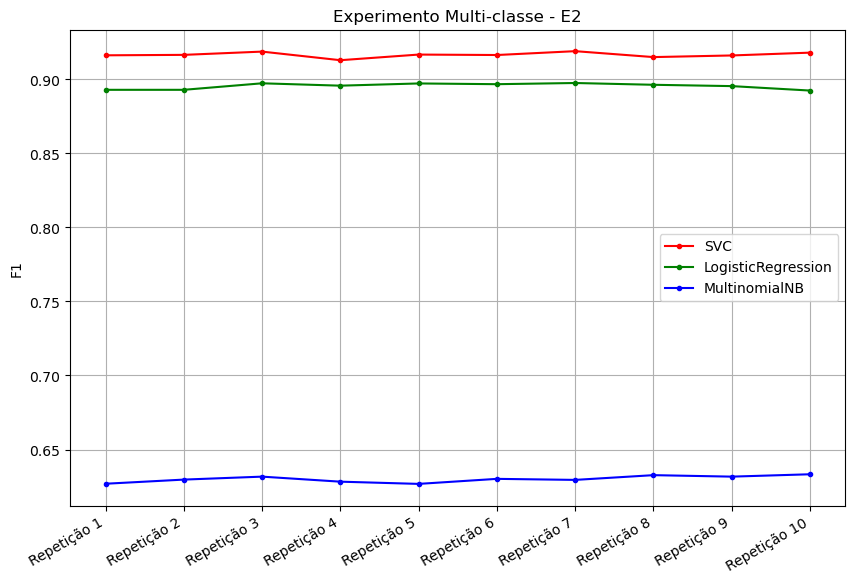

In [33]:
f = plt.figure(figsize=(10, 7)) 
plt.ylabel('F1')
plt.title('Experimento Multi-classe - E2')
plt.plot(label_x.X, df_results_multiclass[df_results_multiclass.Model == 'SVC()'].F1, marker=".",c='red', label='SVC')
plt.plot(label_x.X, df_results_multiclass[df_results_multiclass.Model == 'LogisticRegression()'].F1, marker=".",c='green', label='LogisticRegression')
plt.plot(label_x.X, df_results_multiclass[df_results_multiclass.Model == 'MultinomialNB()'].F1, marker=".",c='blue', label='MultinomialNB')
plt.grid(True)
plt.legend(loc=7)
f.autofmt_xdate()
plt.show()

In [34]:
df_results_multiclass_svc = df_results_multiclass[ df_results_multiclass.Model == "SVC()"]
df_results_multiclass_svc.sort_values(by=['F1'])

,Model,Approach,Accuracy,Precision,Recall,F1,PositiveAndNegativeMetrics,AC_F1,AJ_F1,CRED_F1,N_F1,PA_PIP_F1
Seed,,,,,,,,,,,,
3,SVC(),multiclass,0.9751,0.9674,0.8681,0.9129,"[107, 0, 0, 16, 0, 1, 68, 0, 25, 0, 0, 0, 563,...",0.922414,0.819277,0.888713,0.984890,0.949261
7,SVC(),multiclass,0.9752,0.9664,0.8722,0.9150,"[108, 0, 0, 15, 0, 1, 69, 0, 24, 0, 0, 0, 564,...",0.927039,0.826347,0.886792,0.984923,0.949690
8,SVC(),multiclass,0.9750,0.9674,0.8733,0.9161,"[108, 0, 0, 15, 0, 1, 70, 0, 23, 0, 0, 0, 561,...",0.927039,0.833333,0.886957,0.984779,0.948449
0,SVC(),multiclass,0.9754,0.9673,0.8738,0.9162,"[109, 0, 0, 14, 0, 1, 69, 0, 24, 0, 0, 0, 563,...",0.931624,0.826347,0.888013,0.985067,0.949957
5,SVC(),multiclass,0.9749,0.9679,0.8738,0.9164,"[109, 0, 0, 14, 0, 1, 69, 0, 24, 0, 0, 0, 564,...",0.931624,0.831325,0.885400,0.984735,0.948718
1,SVC(),multiclass,0.9751,0.9693,0.8727,0.9165,"[108, 0, 0, 15, 0, 1, 70, 0, 23, 0, 0, 0, 558,...",0.927039,0.838323,0.882213,0.984852,0.949936
4,SVC(),multiclass,0.9756,0.9672,0.8748,0.9167,"[109, 0, 0, 14, 0, 1, 69, 0, 24, 0, 0, 0, 566,...",0.931624,0.826347,0.890637,0.985135,0.949797
9,SVC(),multiclass,0.9748,0.9671,0.8766,0.9180,"[109, 0, 0, 14, 0, 1, 71, 0, 22, 0, 0, 0, 561,...",0.931624,0.840237,0.885556,0.984672,0.947707
2,SVC(),multiclass,0.9753,0.9694,0.8763,0.9187,"[108, 0, 0, 15, 0, 1, 71, 0, 22, 0, 0, 0, 563,...",0.927039,0.845238,0.886614,0.984993,0.949530


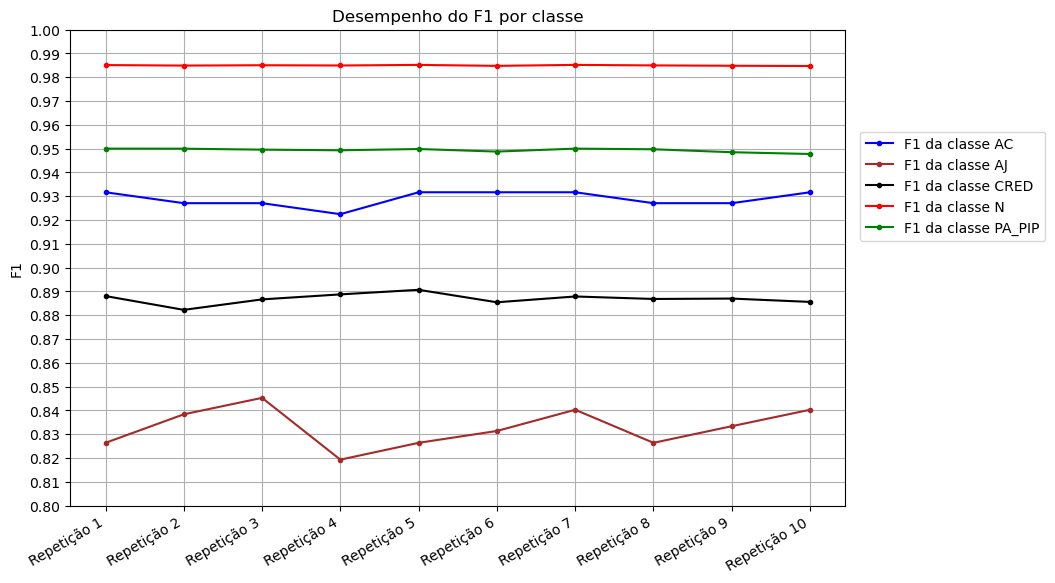

In [35]:
f = plt.figure(figsize=(10, 7)) 
plt.ylabel('F1')
plt.plot(label_x.X, df_results_multiclass_svc.AC_F1, marker=".",c='blue', label='F1 da classe AC')
plt.plot(label_x.X, df_results_multiclass_svc.AJ_F1, marker=".",c='brown', label='F1 da classe AJ')
plt.plot(label_x.X, df_results_multiclass_svc.CRED_F1, marker=".",c='black', label='F1 da classe CRED')
plt.plot(label_x.X, df_results_multiclass_svc.N_F1, marker=".",c='red', label='F1 da classe N')
plt.plot(label_x.X, df_results_multiclass_svc.PA_PIP_F1, marker=".",c='green', label='F1 da classe PA_PIP')
plt.grid(True)
plt.legend(bbox_to_anchor = (1.01,0.8))
plt.yticks(np.arange(0.8, 1.01, 0.01))
f.autofmt_xdate()
plt.title('Desempenho do F1 por classe')
plt.show()

In [36]:
media = df_results_multiclass_svc[['AC_F1', 'AJ_F1','CRED_F1','N_F1','PA_PIP_F1']].mean().round(2)
std = df_results_multiclass_svc[['AC_F1', 'AJ_F1','CRED_F1','N_F1','PA_PIP_F1']].std().round(4)
minimo = df_results_multiclass_svc[['AC_F1', 'AJ_F1','CRED_F1','N_F1','PA_PIP_F1']].min().round(2)
maximo = df_results_multiclass_svc[['AC_F1', 'AJ_F1','CRED_F1','N_F1','PA_PIP_F1']].max().round(2)

In [37]:
media

AC_F1        0.93
AJ_F1        0.83
CRED_F1      0.89
N_F1         0.98
PA_PIP_F1    0.95
dtype: float64

In [38]:
pd.DataFrame([media, minimo, maximo, std], index=['Média', 'Mínimo', 'Máximo', 'Desvio Padrão'])

,AC_F1,AJ_F1,CRED_F1,N_F1,PA_PIP_F1
Média,0.9300,0.8300,0.8900,0.9800,0.9500
Mínimo,0.9200,0.8200,0.8800,0.9800,0.9500
Máximo,0.9300,0.8500,0.8900,0.9900,0.9500
Desvio Padrão,0.0032,0.0082,0.0022,0.0002,0.0008
